# Detect CHARUCO board corners

(latest version on Github at https://github.com/tytell/tytell-lab.git)
This file from commit $Id$

Requires `aniposelib`. Assuming you already have Anaconda python set up, you can install `aniposelib` with 
> % python -m pip install aniposelib

Also requires the Python interface to OpenCV. This should install as part of your normal Anaconda installation, but if it didn't, you can use
> % conda install opencv

Everything else should be standard Python install


In [1]:
import os
import aniposelib
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import re
from collections import defaultdict

Set up to detect a CHaRuCO board. Make sure you identify the number of squares and their size in mm. The numbers below should be correct for the board we have in the lab.

`marker_length`, `marker_bits`, and `dict_size` are particular to the sort of CHaRuCO board that we have in the lab. Don't change them unless you know what you're doing.

In [2]:
board = aniposelib.boards.CharucoBoard(squaresX=6, squaresY=6,
                                        square_length=24.33, marker_length=17, marker_bits=5, dict_size=50)

Fill in the path and the names of video files that have the CHaRuCO images. For paths on Windows machines, be careful not to remove the `r` at the beginning of the quote; without it, all backslashes will be registered as special characters.

In [3]:
videopath = r'Raw data'
videonames = ['9.5.22Calib-camA.mp4', '9.5.22Calib-camB.mp4', '9.5.22Calib-camC.mp4']

This will detect points in the first video, just for testing purposes.

In [4]:
video1 = os.path.join(videopath, videonames[0])
rows = board.detect_video(video1, progress=True)

100%|█████████████████████████████| 1686/1686 [00:22<00:00, 75.09it/s]


This is how many frames were detected.

In [5]:
len(rows)

1660

## Check detected corners

This will load in a frame from the video and show the detected corners.

In [6]:
cap = cv2.VideoCapture(video1)

You can change `i` to look at a different frame

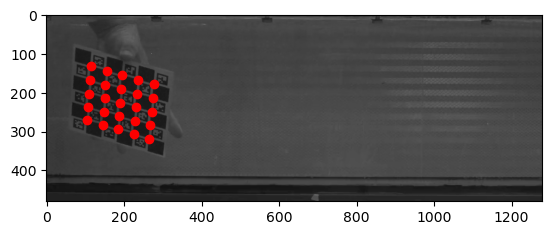

In [7]:
i = 100
fr = rows[i]['framenum']

cap.set(1, fr)
ret, frame = cap.read()

fig, ax = plt.subplots()
ax.imshow(frame)
ax.plot(rows[i]['corners'][:,0,0], rows[i]['corners'][:,0,1], 'ro')

Don't forget to run the code block below to close the video file.

In [8]:
cap.release()

## Calibrate based on all the videos

This will run through all of the videos and detect the corners, then do the calibration and save it out as a `.toml` file

In [151]:
vidnames = [[os.path.join(videopath, fn)] for fn in videonames]
camnames = ['A', 'B', 'C']
ncams = len(vidnames)

camgroup = aniposelib.cameras.CameraGroup.from_names(camnames)

NameError: name 'videopath' is not defined

Run the `aniposelib` functions to calibrate based on the videos, and save out the calibration.

In [20]:
camgroup.calibrate_videos(vidnames, board)
camgroup.dump('calibration.toml')

Raw data/9.5.22Calib-camA.mp4


100%|████████████████████████████| 1686/1686 [00:13<00:00, 126.47it/s]


1660 boards detected
Raw data/9.5.22Calib-camB.mp4


100%|█████████████████████████████| 1686/1686 [00:32<00:00, 52.36it/s]


1685 boards detected
Raw data/9.5.22Calib-camC.mp4


100%|█████████████████████████████| 1686/1686 [00:23<00:00, 72.91it/s]


1686 boards detected
defaultdict(<class 'int'>,
            {('A', 'B'): 1654,
             ('A', 'C'): 1659,
             ('B', 'A'): 1654,
             ('B', 'C'): 1681,
             ('C', 'A'): 1659,
             ('C', 'B'): 1681})
error:  3.769882882849136
n_samples: 100
{(0, 1): (2914, array([1.39352509, 4.58879572])),
 (0, 2): (2914, array([1.57872735, 6.5046211 ])),
 (1, 2): (2914, array([2.2645522 , 7.61005198]))}
error: 3.62, mu: 7.6, ratio: 0.847
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.5777e+03                                    6.52e+06    
       1              2         3.7254e+03      5.85e+03       1.01e+03       6.20e+05    
       2              3         1.8118e+03      1.91e+03       1.26e+02       9.14e+03    
       3              4         1.8086e+03      3.20e+00       1.32e+01       1.25e+02    
       4              5         1.8086e+03      3.93e-02       2.67e+01       8.20e+

In [5]:
camgroup = aniposelib.cameras.CameraGroup.load('calibration.toml')

# Load in the Sleap data files

In [6]:
from sleap.io.dataset import Labels
from sleap.io.video import Video
from sleap import PredictedInstance

In [7]:
sleapfiles = ["Raw data/SeparateCameras/CamA/BigSLEAPturningTraining-camA.slp",
            "Raw data/SeparateCameras/CamB&C/BigSLEAPturningTraining-camB&C.slp",
            "Raw data/SeparateCameras/CamB&C/BigSLEAPturningTraining-camB&C.slp"]

camnames = ["camA", "camB", "camC"]

In [8]:
labels = [Labels.load_file(fn) for fn in sleapfiles]

node_count = len(labels[0].skeletons[0].nodes)
node_names = [node.name for node in labels[0].skeletons[0].nodes]

videos = [[v1.backend.filename for v1 in l1.videos if re.search(c1, v1.backend.filename) is not None] for l1, c1 in zip(labels, camnames)]

In [9]:
def separate_video_and_camera(vidname, camnames):
    fn1 = re.sub(r'\\', '/', vidname)
    fn1 = os.path.basename(fn1)

    for cam1 in camnames:
        fn1, nsub = re.subn(cam1, 'CAMERA', fn1)
        if nsub == 1:
            matched_camera = cam1
            break
    else:
        matched_camera = None

    return fn1, matched_camera

In [10]:
nodenames = [n.name for n in labels[0].skeletons[0].nodes]

ptsall = []
for l1, cam1 in zip(labels, camnames):
    pts = []
    for v1 in l1.videos:
        vidname1, camname1 = separate_video_and_camera(v1.backend.filename, camnames)
        if camname1 != cam1:
            continue
        
        frames = l1.get(v1)
        frame_idx = [lf.frame_idx for lf in frames]

        col_ind = pd.MultiIndex.from_product([[camname1], ['x', 'y']],
                                             names = ['camera', 'point'])
        row_ind = pd.MultiIndex.from_product([[vidname1], frame_idx, nodenames], 
                                             names = ['video', 'frame', 'node'])

        pts1 = pd.DataFrame(index = row_ind, columns=col_ind)

        for lf in frames:
            if len(lf.user_instances) == 1:
                inst = lf.user_instances[0]
            elif len(lf.predicted_instances) == 1:
                inst = lf.predicted_instances[0]
            else:
                print("Error!")
                assert(False)
            
            pts1.loc[(vidname1, lf.frame_idx, slice(None)), (camname1, slice(None))] = inst.numpy()

        pts.append(pts1)
    
    ptsall.append(pd.concat(pts, axis=0))

ptsall = pd.concat(ptsall, axis=1)

In [11]:
ptsall

camera                                                               camA  \
point                                                                   x   
video                               frame node                              
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout                707.526168   
                                          GillCenterLow            748.02   
                                          PelvFinsCenter       781.178769   
                                          MidPelvAnal          807.950671   
                                          AnalBase             818.053275   
...                                                                   ...   
9.7.22Trial18Turn71BLS-CAMERA.mp4   179   PelvFinsCenter       550.839384   
                                          MidPelvAnal          522.046961   
                                          AnalBase             502.586074   
                                          MidAnalBasePeduncle  472.951767   
                                          Peduncle             453.423076   

camera                                                                     \
point                                                                   y   
video                               frame node                              
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout                194.342777   
                                          GillCenterLow            222.92   
                                          PelvFinsCenter       227.122296   
                                          MidPelvAnal          225.924293   
                                          AnalBase             225.924293   
...                                                                   ...   
9.7.22Trial18Turn71BLS-CAMERA.mp4   179   PelvFinsCenter       315.375208   
                                          MidPelvAnal          311.781198   
                                          AnalBase             307.859678   
                                          MidAnalBasePeduncle   281.94731   
                                          Peduncle              274.33777   

camera                                                                camB  \
point                                                                    x   
video                               frame node                               
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout                    1252.28   
                                          GillCenterLow             1340.9   
                                          PelvFinsCenter           1398.11   
                                          MidPelvAnal          1435.700043   
                                          AnalBase             1471.253292   
...                                                                    ...   
9.7.22Trial18Turn71BLS-CAMERA.mp4   179   PelvFinsCenter            937.84   
                                          MidPelvAnal               891.74   
                                          AnalBase                   863.9   
                                          MidAnalBasePeduncle   815.622331   
                                          Peduncle              764.844928   

camera                                                                     \
point                                                                   y   
video                               frame node                              
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout                    498.26   
                                          GillCenterLow            491.06   
                                          PelvFinsCenter           491.36   
                                          MidPelvAnal          483.431097   
                                          AnalBase             481.959874   
...                                                                   ...   
9.7.22Trial18Turn71BLS-CAMERA.mp4   179   PelvFinsCenter

In [12]:
q = ptsall.stack().to_numpy().reshape((-1, 2, 3))
q = q.transpose([2, 0, 1])

q.shape


(3, 2897, 2)

In [20]:

camgroup.triangulate(q[:,0,:], progress=True, undistort=False)

  0%|                                           | 0/1 [00:00<?, ?it/s]


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [18]:
camgroup.cameras[0].matrix

array([[4.87300054e+03, 0.00000000e+00, 6.39500000e+02],
       [0.00000000e+00, 4.87300054e+03, 2.39500000e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])